## FPF calibration
Guide user towards what would be an appropriate FPF value to help ensure that targets get met. 
This step is connected to The unmet target workflow (it only increaes the fpf value of the features that have not been met)
Similar to the BLM calibration, the steps include:

1. Run the same scenario 6 times, 10 runs each, modifying the FPF value multiplied by a fixed range: 1,2,5,10,20,50,100
2. Retrieve best solution file from each scenario
4. Calculate the optimum FPF value that minimizes the missed targets

REQUIREMENTS:
- dict of unmet features (we could think of increasing all FPF values, so it could be used before running marxan)--> output of running the unmet workflow
- output_mvbest.csv (Columns 'Target' and 'Misslevel')

In [1]:
%run marxan_utils.ipynb 

In [2]:
def createFpfProject(MARXAN_FOLDER: str, MARXAN_INPUTDATA:str, unmet_dict: dict) -> list:
    
    ### RUN MARXAN several times
    fpf_range= [1,2,5,10,20,50,100]
    fpf_folder=[]

    for fpf in fpf_range:
        print(f'\033[1m --> Running FPF_{fpf}...\033[0m')
        
        ## Create a folder for each FPF run at the same level as the original folder, 
        ## remove  folder if there is a previous one
        ## copy all  files except outputs
        if os.path.exists(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}'):
            rmtree(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}')
        copytree(MARXAN_FOLDER, f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}',ignore=ignore_patterns('output_*'))
        
            
        ## Read input files
        userInputFile = readInput(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}', MARXAN_INPUTDATA)
        userInputFile.NUMREPS = 10
        userInputFile.VERBOSITY = 0
        saveInput(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}', MARXAN_INPUTDATA,userInputFile)
        
        spec = validateFile(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}',MARXAN_INPUTDATA, conservationFeature)
        
        unmet = list(unmet_dict.keys())
        for feature in unmet:
            spec.loc[spec['id'] == feature,'spf'] = (spec[spec['id'] == feature].spf)*fpf
        CreateFileFromDF(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}/{userInputFile.INPUTDIR}/{userInputFile.SPECNAME}',spec, conservationFeature) 
        
        if not os.path.exists(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}/{userInputFile.OUTPUTDIR}'):
            os.mkdir(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}/{userInputFile.OUTPUTDIR}')

        fpf_folder.append(f'FPF_{fpf}')
        os.chmod(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}/marxan', 0o755)
        execute_marxan(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}')
    
    return fpf_folder

In [5]:
def FPF_calibration(MARXAN_FOLDER: str, MARXAN_INPUTDATA :str, unmet_dict: dict, Plot: bool = True)-> float:
    fpf_df =pd.DataFrame(columns=['folder','multiplier','missed_targets'])
    fpf_folder = createFpfProject(MARXAN_FOLDER, MARXAN_INPUTDATA, unmet_dict)
    fpf_df['folder'] = fpf_folder
    fpf_df['multiplier']= [int(i.split('_')[1]) for i in fpf_folder]

    for fpf in fpf_folder:
        # using mvbest
        mvbest = validateFile(f'{os.path.dirname(MARXAN_FOLDER)}/{fpf}',MARXAN_INPUTDATA, OutputMV)
        fpf_df.loc[fpf_df['folder']==fpf,'missed_targets']= len(mvbest[mvbest['Target_Met'] == 'no'])
        
        # using an average of all the runs
        # summary = validateFile(f'{os.path.dirname(MARXAN_FOLDER)}/{fpf}',MARXAN_INPUTDATA, OutputSum)
        # fpf_df.loc[blm_df['folder']==fpf,'missed_targets']= summary['Missing_Values'].mean()
    
    ###Curve with no fit
    y = fpf_df['missed_targets']
    x = fpf_df['multiplier']

    best_fpf = fpf_df.loc[fpf_df['missed_targets'] == min(fpf_df.missed_targets),'multiplier'].values[0]
    
    if Plot==True:
        fig = plt.figure(figsize=(5,5))
        plt.xlabel('FPF multiplier')
        plt.ylabel('Missed targets')
        plt.plot(x, y, 'bo-')
    print(f'the lowest fpf that minimizes missed targets is = {best_fpf}')    
    return best_fpf

In [6]:
#MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/demo_marxan_okavango/Marxan_okavango_v5'
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/demo_Coral_Triangle/marxan_Coral_Triangle_Case_Study'
MARXAN_INPUTDATA = 'input.dat'

In [7]:
userInputFile = readInput(MARXAN_FOLDER, MARXAN_INPUTDATA)
userInputFile

inputDatFile(VERSION='0.1', BLM=0.0, PROP=0.5, RANDSEED=-1, NUMREPS=100, BESTSCORE=10, NUMITNS=1000000, STARTTEMP=-1, COOLFAC=6, NUMTEMP=10000, COSTTHRESH=0.0, THRESHPEN1=14.0, THRESHPEN2=1.0, INPUTDIR='input', SPECNAME='spec.dat', PUNAME='pu.dat', PUVSPRNAME='puvspr.dat', BOUNDNAME='boundary.dat', BLOCKDEFNAME='blockdef.dat', VERBOSITY=0, MISSLEVEL=1.0, OUTPUTDIR='output', SCENNAME='output', SAVERUN=3, SAVEBEST=3, SAVESUMMARY=3, SAVESCEN=3, SAVETARGMET=3, SAVESUMSOLN=3, SAVELOG=2, SAVESNAPSTEPS=0, SAVESNAPCHANGES=0, SAVESNAPFREQUENCY=0, SAVESOLUTIONSMATRIX=3, RUNMODE=1, ITIMPTYPE=0, HEURTYPE=-1, CLUMPTYPE=0)

### First run unmet targets pipeline to detect features misisng

In [10]:
unmet_dict = unmetDecisionTree(MARXAN_FOLDER, MARXAN_INPUTDATA,
                      lock_out_limit=0.5, 
                      high_cost_quantile= 0.7, 
                      hcost_limit=0.2)
unmet_dict

{1: 'Close to target (1% away of misslevel)',
 2: 'Close to target (1% away of misslevel)',
 5: 'Close to target (1% away of misslevel)',
 6: 'Close to target (1% away of misslevel)',
 7: 'Close to target (1% away of misslevel)',
 9: 'Close to target (1% away of misslevel)'}

 --> Running FPF_1...
Marxan v 4.0.5

Spatial Prioritization via Annealing

Coded by Ian Ball, modified by Matthew Watts
Written by Ian Ball and Hugh Possingham

Marxan website

https://marxansolutions.org/

Running multithreaded over number of threads: 4

Best run: 1 Best score: 3.89587e+07
 --> Running FPF_2...
Marxan v 4.0.5

Spatial Prioritization via Annealing

Coded by Ian Ball, modified by Matthew Watts
 --> Running FPF_5...
Marxan v 4.0.5

Spatial Prioritization via Annealing

Coded by Ian Ball, modified by Matthew Watts
Written by Ian Ball and Hugh Possingham

Marxan website

https://marxansolutions.org/

Running multithreaded over number of threads: 4

Best run: 1 Best score: 4.07436e+07
 --> Running FPF_10...
Marxan v 4.0.5

Spatial Prioritization via Annealing

Coded by Ian Ball, modified by Matthew Watts
Written by Ian Ball and Hugh Possingham

Marxan website

https://marxansolutions.org/

Running multithreaded over number of threads: 4

Best run: 9 Best score: 4.18247e+07

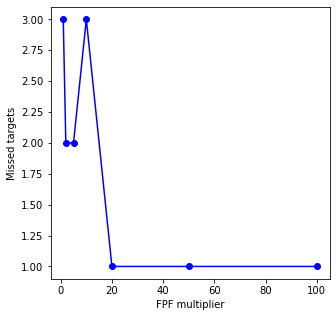

In [11]:
best_multiplier = FPF_calibration(f'{MARXAN_FOLDER}',MARXAN_INPUTDATA, unmet_dict)